#  Dog vs Cat - Training Deep Convolutional Neural Network

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use  Cat vs Dog dataset.

See https://www.kaggle.com/c/dogs-vs-cats/data


### Dog or Cat Application 

Now, it time to put everything together and develop and Cat vs Dog classifier model. 

- cat and dog dataset contain total of 25000 images, 12500 for cat and other half for a dog.

- load a data into a project using any method 
   

```
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip
```



### 1.Load Data

In [1]:
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq Cat_Dog_data.zip

--2019-11-01 02:55:19--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.164.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.164.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  22.7MB/s    in 21s     

2019-11-01 02:55:41 (25.9 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



In [2]:
from tensorflow import keras
from keras import models
from keras.applications import vgg16
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from keras.layers.convolutional import  MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras import regularizers


Using TensorFlow backend.


In [0]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,labels,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        
        #plt.set_title(layer_name)
        fig,ax = plt.subplots()
        ax.set_title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)  

In [0]:
import cv2 as cv
import os

def load_images_from_folder(folder):
    images = []
    label = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        img = cv.resize(img,(224,224))
        name = filename.split(".")
        if img is not None:
            images.append(img)

            if name[0] == 'cat':
              label.append(0)
            elif name[0] == 'dog':
              label.append(1)

    return images,label

In [0]:
(test_images_cat, test_labels_cat) = load_images_from_folder('/content/Cat_Dog_data/test/cat')
(test_images_dog, test_labels_dog) = load_images_from_folder('/content/Cat_Dog_data/test/dog')

In [0]:
#concatenate
test_images = np.concatenate((test_images_cat, test_images_dog), axis=0)
test_labels = np.concatenate((test_labels_cat, test_labels_dog), axis=0)

In [0]:
from numpy import asarray

test_images = asarray(test_images)
test_labels = asarray(test_labels)

In [0]:
test_labels = np_utils.to_categorical(test_labels)

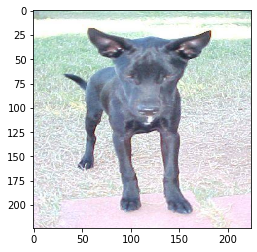

In [9]:
plt.imshow(cv.cvtColor( test_images[1250], cv.COLOR_BGR2RGB))

In [10]:
test_labels[1250]

array([0., 1.], dtype=float32)

Model

### 2.Build a convolutional neural network 

In [0]:
from keras.applications import vgg16

In [12]:
# Load pre train model
pre_vgg = vgg16.VGG16(include_top=False, input_shape=(224, 224, 3))

# Set the last pre- trained block to be trainable
pre_vgg.trainable = True
set_trainable = False
for layer in pre_vgg.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
# add new layer 
new_vgg = models.Sequential()
new_vgg.add(pre_vgg)
new_vgg.add(layers.Flatten())
new_vgg.add(layers.Dropout(0.5))
new_vgg.add(layers.Dense(256, activation='relu', kernel_initializer='he_uniform',
                kernel_regularizer=regularizers.l2(0.0001),
                activity_regularizer=regularizers.l1(0.0001)))
new_vgg.add(layers.Dense(2, activation='softmax'))
new_vgg.summary()

# compile model
opt = optimizers.SGD(lr=0.001, momentum=0.9)
new_vgg.compile(optimizers.RMSprop(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])





58892288/58889256 [==============================] - 22s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 13,502,722
Non-tr

### 3.Preprocess data 

##### Augmentation

In [13]:
# create data generator for data augmentation
datagen_aug = ImageDataGenerator(featurewise_center=True,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       channel_shift_range=10,
                                       horizontal_flip=True,
                                       fill_mode='nearest',
                                       validation_split=0.1)

# specify imagenet mean values for centering
datagen_aug.mean = [123.68, 116.779, 103.939]

train_generator_aug = datagen_aug.flow_from_directory('/content/Cat_Dog_data/train/',
		class_mode='categorical', batch_size=32, shuffle=True, subset='training', target_size=(224, 224))

validate_generator_aug = datagen_aug.flow_from_directory('/content/Cat_Dog_data/train/',
		class_mode='categorical', batch_size=32, shuffle=True, subset='validation', target_size=(224, 224))

Found 20250 images belonging to 2 classes.
Found 2250 images belonging to 2 classes.


### 4.Model Training

In [14]:
history_aug = new_vgg.fit_generator(train_generator_aug, steps_per_epoch=len(train_generator_aug),
		validation_data=validate_generator_aug, validation_steps=len(validate_generator_aug), epochs=10, verbose=1)



Epoch 1/10
633/633 [==============================] - 325s 514ms/step - loss: 1.3963 - acc: 0.7705 - val_loss: 0.3853 - val_acc: 0.9076
Epoch 2/10
633/633 [==============================] - 316s 499ms/step - loss: 0.3542 - acc: 0.9282 - val_loss: 0.2290 - val_acc: 0.9449
Epoch 3/10
633/633 [==============================] - 317s 501ms/step - loss: 0.2352 - acc: 0.9531 - val_loss: 0.1904 - val_acc: 0.9591
Epoch 4/10
633/633 [==============================] - 321s 506ms/step - loss: 0.1899 - acc: 0.9624 - val_loss: 0.1605 - val_acc: 0.9693
Epoch 5/10
633/633 [==============================] - 320s 505ms/step - loss: 0.1633 - acc: 0.9674 - val_loss: 0.1492 - val_acc: 0.9667
Epoch 6/10
633/633 [==============================] - 318s 502ms/step - loss: 0.1452 - acc: 0.9726 - val_loss: 0.1298 - val_acc: 0.9698
Epoch 7/10
633/633 [==============================] - 320s 505ms/step - loss: 0.1350 - acc: 0.9736 - val_loss: 0.1272 - val_acc: 0.9751
Epoch 8/10
633/633 [==========================

Last train accuracy: 0.9799012345325799
Last validation accuracy: 0.9688888888888889


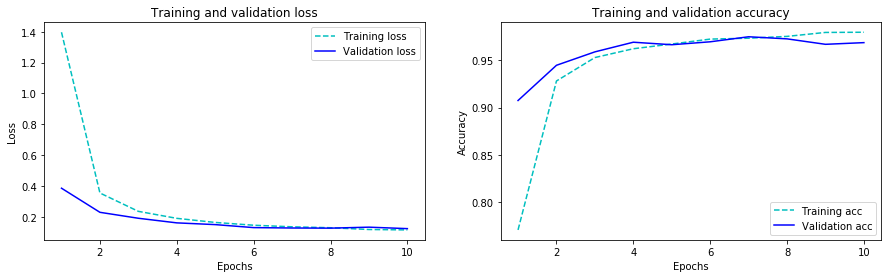

In [15]:
show_result(history_aug)

### 5.Evaluation model

In [19]:
evaluation = evaluation_report(new_vgg,test_images,test_labels)

[[1219   31]
 [  23 1227]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1250
           1       0.98      0.98      0.98      1250

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500

Loss: 0.12212629370689392 Accuracy: 0.9784


### 6. Visualize Layer Activation 


In [21]:
# Create an activation model (the model with convolution layer only)

layer_outputs = [layer.output for layer in pre_vgg.layers[1:18]]
activation_model = models.Model(inputs=pre_vgg.inputs, outputs=layer_outputs)
activation_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
from keras.preprocessing import image

# load image to feed into network
img = image.load_img('/content/test.jpg',target_size=(224,224),grayscale=False)
img_tensor = image.img_to_array(img)

# Preprocess data
img_tensor = np.expand_dims(image.img_to_array(img),axis=0)/255
img_tensor = img_tensor.reshape(1,224, 224 , 3).astype('float32')
img_tensor = img_tensor - [123.68, 116.779, 103.939]

# Feed into activation model to get an activation value
activation = activation_model.predict(img_tensor)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 1152x288 with 0 Axes>

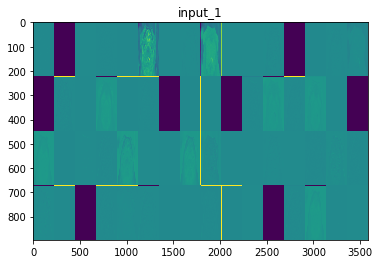

<Figure size 1152x288 with 0 Axes>

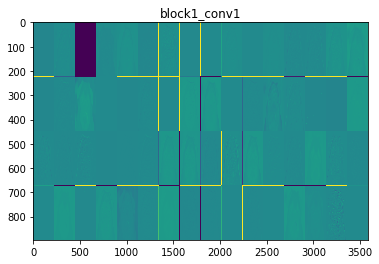

<Figure size 1152x288 with 0 Axes>

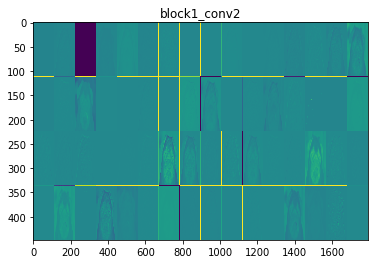

<Figure size 1152x576 with 0 Axes>

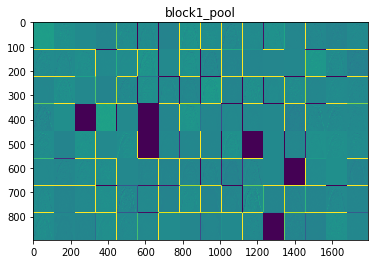

<Figure size 1152x576 with 0 Axes>

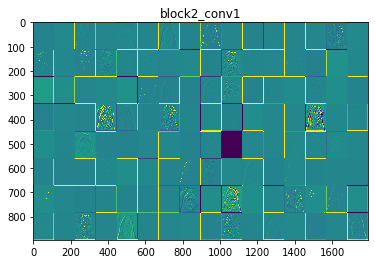

<Figure size 1152x576 with 0 Axes>

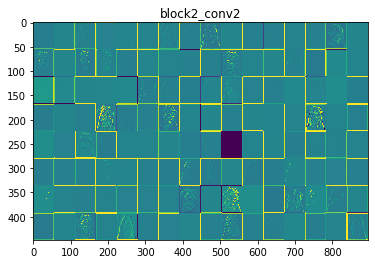

<Figure size 1152x1152 with 0 Axes>

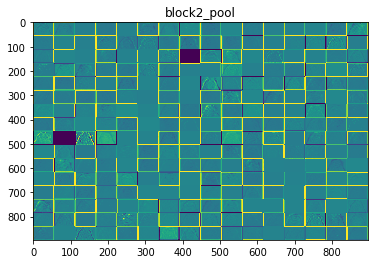

<Figure size 1152x1152 with 0 Axes>

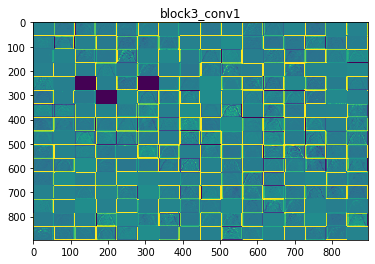

<Figure size 1152x1152 with 0 Axes>

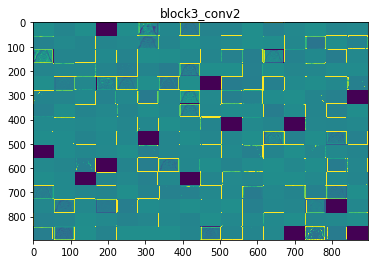

<Figure size 1152x1152 with 0 Axes>

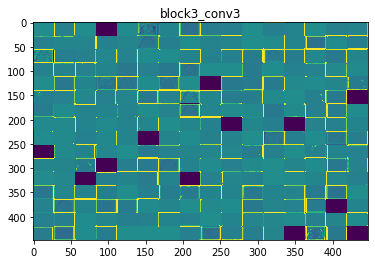

<Figure size 1152x2304 with 0 Axes>

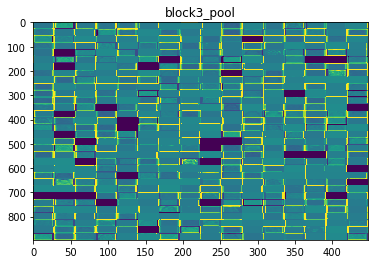

<Figure size 1152x2304 with 0 Axes>

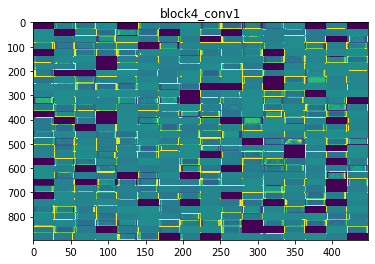

<Figure size 1152x2304 with 0 Axes>

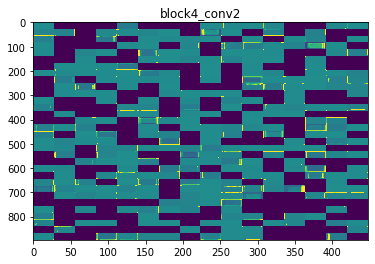

<Figure size 1152x2304 with 0 Axes>

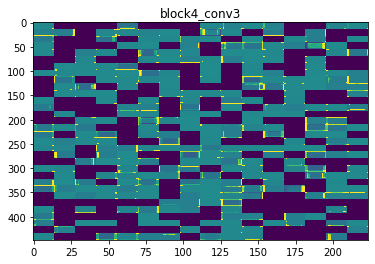

<Figure size 1152x2304 with 0 Axes>

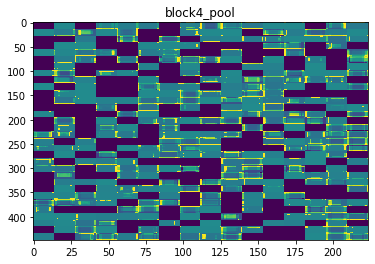

<Figure size 1152x2304 with 0 Axes>

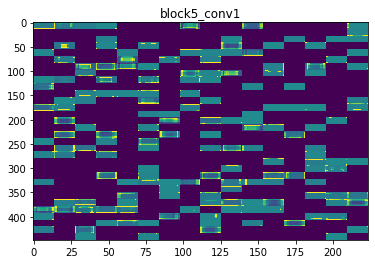

<Figure size 1152x2304 with 0 Axes>

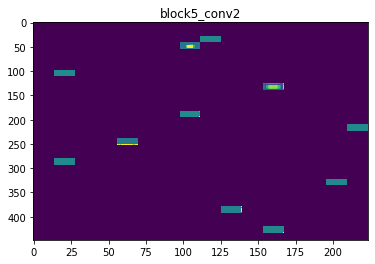

In [23]:
 ### Feed your model and number of layer you want to show 
show_layer_activation(activation,pre_vgg,18)